In [ ]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import ast # Abstract Syntax Trees; a built-in standard library module that allows you to interact with Python code as a tree of Python objects

import tensorflow as tf
from keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import confusion_matrix
import warnings

In [ ]:
# Note for CSV
# Identifiers: ecg id and encoded patient id
# General: demographic and recording metadata (age, sex, height, weight, nurse, site, device, recording_date)
# ECG statements: incl SCP_codes (e.g., {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0})
# Signal Metadata: signal quality data like noise, baseline drifts, and other artifacts/problems preventing clean data
# Cross validation folds (strat_fold)
# lr_filename and hr_filename: filenames for the 100Hz and 500Hz sampled ECG signals
# Note for SCP_codes!:
# num of records    superclass   description (Rhythm)
#   9528            NORM 	     Normal ECG
#   5486 	        MI 	         Myocardial Infarction
#   5250 	        STTC 	     ST/T Change
#   4907 	        CD 	         Conduction Disturbance
#   2655 	        HYP 	     Hypertrophy


# for rhythm labels
# rhythm classes: ['SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR', 'BIGU', 'AFLT', 'SVTAC', 'PSVT', 'TRIGU']
# SR: Sinus Rhythm - normal heart rhythm
# AFIB: Atrial Fibrillation - irregular and often rapid heart rate
# STACH: Sinus Tachycardia - increased heart rate
# SARRH: Sinus Arrhythmia - irregular heart rhythm
# SBRAD: Sinus Bradycardia - decreased heart rate
# PACE: Paced Rhythm - heart rhythm controlled by a pacemaker
# SVARR: Supraventricular Arrhythmia - arrhythmia originating above the ventricles
# BIGU: Bigeminy - extra heartbeat between every normal, expected heartbeat
# AFLT: Atrial Flutter - rapid heart rate due to reentrant circuit in the atria
# SVTAC: Supraventricular Tachycardia - rapid heart rate originating above the ventricles
# PSVT: Paroxysmal Supraventricular Tachycardia - sudden onset of rapid heart rate
# TRIGU: Trigeminy - three consecutive beats of different types (e.g., normal followed by two premature beats)


In [2]:
# Dir holding all the PTB-XL data (including csv)
data_dir = 'C:\\Users\\Owner\\VS Code Projects\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'

# Create dataframe from CSV that contains the patient metadata 
df = pd.read_csv(os.path.join(data_dir, "ptbxl_database.csv"))

# Read in the SCP statements
scp_statements = pd.read_csv(os.path.join(data_dir, "scp_statements.csv"), index_col=0)

#print("head\n",scp_statements.head(),"\n\n")
#print("cols\n",scp_statements.columns,"\n\n")
#print("unique\n",scp_statements["diagnostic_class"].unique())

In [3]:
# Picking only "Rhythm" statements (which identify rhythm abnormalities) for getting labels...
rhythm_classes = scp_statements[scp_statements["rhythm"] == 1.0].index.tolist()
#print(rhythm_classes)

# For every row, get a label vector (rhythm_label_vec) (i.e., build targets) given the function and .apply
def get_rhythm_labels(scp_codes_str):
    scp_codes = ast.literal_eval(scp_codes_str) # convert string of literals (int, list, dict, etc.) to the actual Python object (e.g. string of dict -> actual dict)
    labels = np.zeros(len(rhythm_classes), dtype=np.float32) # For one hot vector -> Dict for all possible rhythm labels, initialized to 0 (and will be set to 1 next if detected) 
    for i, c in enumerate(rhythm_classes): # starting index at 0
        if c in scp_codes:
            labels[i] = 1 # set 1's for one-hot vector, indicating which rhythms are present in codes dict
    return labels
df["rhythm_labels"] = df["scp_codes"].apply(get_rhythm_labels) # apply the get_rhythm_labels(<element>) function to each element of Series (df['scp_codes']) to get one-hot vectors for each


In [4]:
def load_hr_record(record_row, base_dir=data_dir):
    rec_basename = record_row['filename_hr']   # pick high-res (500 Hz) to test
    rec_path = os.path.join(base_dir, rec_basename)
    signals, fields = wfdb.rdsamp(rec_path) # rdsamp returns the signal and the metadata fields of the input ecg record
    return signals, fields                     
    # signals: (n_samples, n_leads) -> samples is number of time points across this one ecg (leads=12 e.g. if 12 lead ecg)
    # fields: a dict of metadata about the record (e.g. fs, units, sig_name, etc.)

In [ ]:
def make_rhythm_cnn(input_len=2500, n_leads=12, n_classes=len(rhythm_classes)):
    inp = layers.Input((input_len, n_leads))
    x = layers.Conv1D(32, 7, padding='same', activation='relu')(inp) # lower level features for wider receptive field (7 time steps)
    x = layers.BatchNormalization()(x) # stabilize learning (improve generalization and speed up training)
    x = layers.MaxPool1D(4)(x) # downsamples by factor of 4 - to reduce sequence length (to reduce computation/complexity and avoid overfitting - help with spatial invariance)
    for f in [64, 128]: # higher level features
        x = layers.Conv1D(f, 5, padding='same', activation='relu')(x) # smaller receptive field (5 time steps) for more detail focus
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool1D(4)(x)
        x = layers.SpatialDropout1D(0.1)(x) # prevent overfitting by randomly dropping channels during training - unlike standard Dropout, spatial version drops entire channels/filters which forces the model to use multiple filters, which is better generalization for time series like ecg
    x = layers.GlobalAveragePooling1D()(x) # reduce var-length sequence into a single vector per filter (averages across time); remove time dimension, so input is now (features,)
    x = layers.Dense(128, activation='relu')(x) # pull together high level features
    out = layers.Dense(n_classes, activation='sigmoid')(x) # finish (assign labels): n_classes outputs, with sigmoid (multi-label, so we have probabilities per independent class)
    model = models.Model(inp, out)
    # Loss: binary_crossentropy since multi-label classification
    # Metric: AUC (area under ROC curve), common for medical problems
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='auc')])
    return model


In [6]:
def ecg_generator(df, base_dir=data_dir, input_len=2500, n_leads=12, skip_missing=True): # so overall, 2500 is for time points, and we get 2500 per lead (since we want 5 sec of data from each - for default at least)
    """
    Output --> (signal amplitude at each time point in mV for each lead [x; input_len by n_leads], corresponding label vector [y] for classes)

    Inputs
    ----------
    df        
    base_dir (holding all the ptb-xl data)
    input_len : int, number of time points per ECG (may trim/pad to 2500 depending on length)
    n_leads
    skip_missing : True if we want to just skip files that can't be found instead of raise error
    """
    for _, row in df.iterrows(): # go through all rows to get each corresponding ecg record's filepath
        rec_basename = row['filename_hr']  # change to 'filename_lr' if want to try low-res!
        rec_path = os.path.join(base_dir, rec_basename)
        
        # Check that both .hea and .dat exist b/c we need BOTH the header (metadata) and actual waveform data
        if not os.path.exists(rec_path + ".hea") or not os.path.exists(rec_path + ".dat"):
            if skip_missing:
                print(f"Skipping missing file: {rec_path}")
                continue
            else:
                raise FileNotFoundError(f"{rec_path} .hea or .dat not found.")
        
        # Load ECG
        signals, _ = wfdb.rdsamp(rec_path) # rdsamp returns the signal (but skip the metadata fields) of the input ecg record

        # Trim/pad to fixed length - we are assuming 2500 for this project anyways, but can always have this later for flexibility with input length
        x = signals[:input_len, :]
        if x.shape[0] < input_len:
            pad_width = input_len - x.shape[0]
            x = np.pad(x, ((0, pad_width), (0, 0)), mode='constant')
        
        y = row['rhythm_labels']
        yield x.astype(np.float32), y.astype(np.float32) # yield is better than return for single batch/sample looping
                                                         # -> helps us return the (x, y) pair to the caller without stopping the generator + and the generator will remember its state and can produce the next (x, y) on the next call
                                                         # thus we can both continue running the generator while we get the next (x, y) pair in a memory efficient manner

In [7]:
# Split off a test set (15% of dataset) for final eval later
df_trainval, df_test = train_test_split(
    df, 
    test_size=0.15, 
    stratify=df['rhythm_labels'].apply(lambda x: np.argmax(x)),  # optional to stratify by main rhythm
    random_state=51 # just b/c
)


--- Fold 1 ---
Epoch 1/5
    464/Unknown 135s 269ms/step - auc: 0.9377 - loss: 0.1523

C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


464/464 ━━━━━━━━━━━━━━━━━━━━ 158s 318ms/step - auc: 0.9632 - loss: 0.1098 - val_auc: 0.9755 - val_loss: 0.0904
Epoch 2/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 126s 260ms/step - auc: 0.9774 - loss: 0.0856 - val_auc: 0.9816 - val_loss: 0.0787
Epoch 3/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 120s 249ms/step - auc: 0.9806 - loss: 0.0791 - val_auc: 0.9837 - val_loss: 0.0763
Epoch 4/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 143s 300ms/step - auc: 0.9826 - loss: 0.0744 - val_auc: 0.9843 - val_loss: 0.0743
Epoch 5/5
464/464 ━━━━━━━━━━━━━━━━━━━━ 145s 297ms/step - auc: 0.9842 - loss: 0.0717 - val_auc: 0.9851 - val_loss: 0.0720
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - auc: 0.9851 - loss: 0.0720


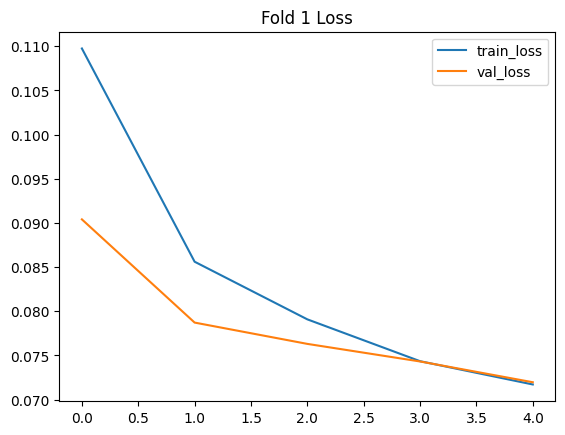


--- Fold 2 ---
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 123s 247ms/step - auc: 0.9611 - loss: 0.1104 - val_auc: 0.9672 - val_loss: 0.0980
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 119s 246ms/step - auc: 0.9770 - loss: 0.0866 - val_auc: 0.9820 - val_loss: 0.0777
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 109s 226ms/step - auc: 0.9808 - loss: 0.0797 - val_auc: 0.9839 - val_loss: 0.0756
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 108s 223ms/step - auc: 0.9832 - loss: 0.0747 - val_auc: 0.9835 - val_loss: 0.0702
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - auc: 0.9842 - loss: 0.0719 - val_auc: 0.9842 - val_loss: 0.0723
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - auc: 0.9842 - loss: 0.0723


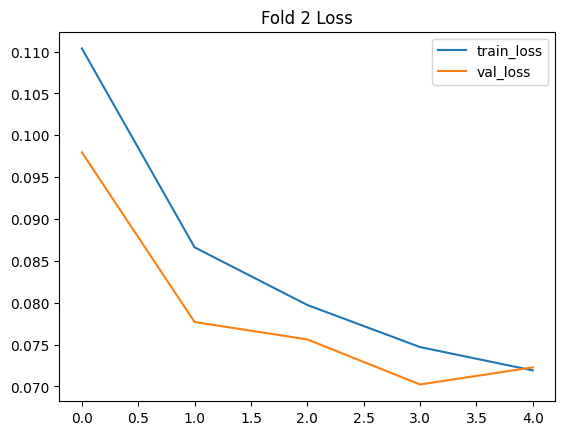


--- Fold 3 ---
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 110s 222ms/step - auc: 0.9614 - loss: 0.1124 - val_auc: 0.9698 - val_loss: 0.1020
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 105s 216ms/step - auc: 0.9777 - loss: 0.0848 - val_auc: 0.9823 - val_loss: 0.0808
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 104s 216ms/step - auc: 0.9807 - loss: 0.0795 - val_auc: 0.9831 - val_loss: 0.0766
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 105s 216ms/step - auc: 0.9826 - loss: 0.0751 - val_auc: 0.9833 - val_loss: 0.0763
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 104s 216ms/step - auc: 0.9840 - loss: 0.0718 - val_auc: 0.9846 - val_loss: 0.0710
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - auc: 0.9846 - loss: 0.0710


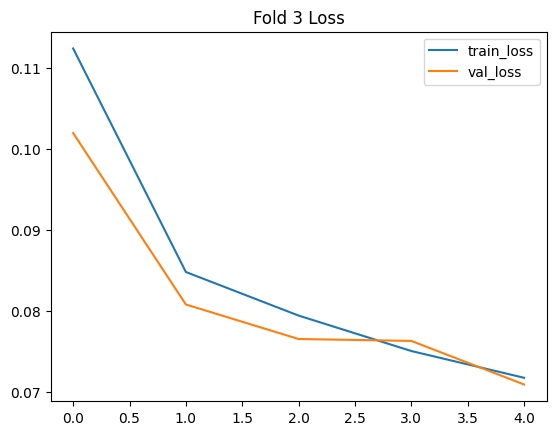


--- Fold 4 ---
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 103s 208ms/step - auc: 0.9616 - loss: 0.1117 - val_auc: 0.9698 - val_loss: 0.1056
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 100s 206ms/step - auc: 0.9776 - loss: 0.0856 - val_auc: 0.9795 - val_loss: 0.0822
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 99s 204ms/step - auc: 0.9811 - loss: 0.0785 - val_auc: 0.9830 - val_loss: 0.0770
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 99s 205ms/step - auc: 0.9830 - loss: 0.0749 - val_auc: 0.9843 - val_loss: 0.0731
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 115s 237ms/step - auc: 0.9838 - loss: 0.0726 - val_auc: 0.9834 - val_loss: 0.0732
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - auc: 0.9834 - loss: 0.0732


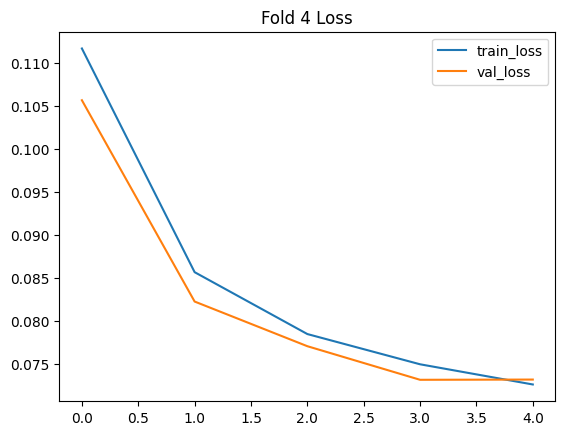


--- Fold 5 ---
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 109s 219ms/step - auc: 0.9606 - loss: 0.1145 - val_auc: 0.9669 - val_loss: 0.0977
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 123s 255ms/step - auc: 0.9774 - loss: 0.0859 - val_auc: 0.9797 - val_loss: 0.0820
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 158s 328ms/step - auc: 0.9807 - loss: 0.0792 - val_auc: 0.9820 - val_loss: 0.0768
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 182s 373ms/step - auc: 0.9829 - loss: 0.0745 - val_auc: 0.9837 - val_loss: 0.0730
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 174s 357ms/step - auc: 0.9843 - loss: 0.0713 - val_auc: 0.9837 - val_loss: 0.0728
116/116 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - auc: 0.9837 - loss: 0.0728


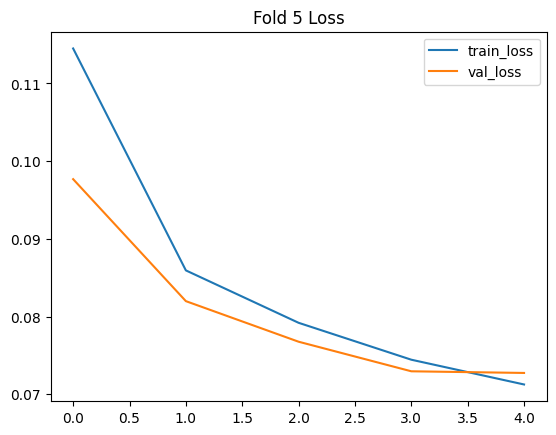


=== Cross-validation results ===
Avg Validation Loss: 0.0722 ± 0.0008
Avg Validation AUC : 0.9842 ± 0.0006


In [ ]:
# CROSS-VALIDATION to figure out best hyperparameters 
# (input_L, batch_size, CNN depth / filters, kernel sizes for conv1D, 
# Dropout 0-0.3 to prevent overfitting, learning rate 0.001 (Adam default), can adjust up/down by 2–5× if training unstable)

groups = df_trainval['patient_id'] # use only our training+val set (reserve test set for later)
gkf = GroupKFold(n_splits=5)

val_losses, val_aucs = [], [] # to hold our losses and AUCs for outputting our final average results
num_leads=12 # fixed based on all 12 lead based dataset (pretty sure...)

input_L=2500 # 5 seconds worth of samples for 500Hz data
batch_size=32 # num examples per mini batch

fold = 1
# now we can split into our train + val datasets and prep them
for train_idx, val_idx in gkf.split(df_trainval, groups=groups, y=None): 
    
    print(f"\n--- Fold {fold} ---")

    train_df = df_trainval.iloc[train_idx]
    val_df = df_trainval.iloc[val_idx]

    # Build datasets
    # Assume 2500 samples for length (just so we have 5sec of 500Hz data - want enough but not overboard) and 12 for # of leads
    train_dataset = tf.data.Dataset.from_generator(
        lambda: ecg_generator(train_df, base_dir=data_dir, input_len=input_L, n_leads=num_leads),
        output_signature=(
            tf.TensorSpec(shape=(input_L, num_leads), dtype=tf.float32),
            tf.TensorSpec(shape=(len(rhythm_classes),), dtype=tf.float32)
        )
    ).shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE) # prefetch lets us prepare data while the model is training! While the GPU is training on a batch, the CPU prepares the next batch
    # also, AUTOTUNE just lets tf auto choose the best prefetch buffer size for system (b/c idk what it is)

    val_dataset = tf.data.Dataset.from_generator(
        lambda: ecg_generator(val_df, base_dir=data_dir, input_len=input_L, n_leads=num_leads),
        output_signature=(
            tf.TensorSpec(shape=(input_L, num_leads), dtype=tf.float32),
            tf.TensorSpec(shape=(len(rhythm_classes),), dtype=tf.float32)
        )
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # New model for each fold
    model = make_rhythm_cnn(input_len=input_L, n_leads=num_leads, n_classes=len(rhythm_classes))

    # Train
    history = model.fit(train_dataset, epochs=5, validation_data=val_dataset) # epochs low for now just while we are finding best model - then can increase to 5-15 for hyperpar tuning, or 20-50+ for final trianing

    # Evaluate
    val_loss, val_auc = model.evaluate(val_dataset)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    # Plot training curves for this fold - x-axis: epochs, y-axis: loss (binary cross-entropy)
    # Interpretation: 
    # Training loss curve
    #       -> Shows how well the model fits the training data
    #       -> If it decreases smoothly, the model is learning; if it stagnates or increases, learning may be too slow or the learning rate is off
    # Validation loss curve measures generalization on unseen data for that fold
    #       -> If it starts increasing while training loss decreases → overfitting
    #       -> If it mirrors training loss → good fit

    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"Fold {fold} Loss")
    plt.legend()
    plt.show()
    
    fold += 1

# Average results across folds
print("\n=== Cross-validation results ===")
print(f"Avg Validation Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Avg Validation AUC : {np.mean(val_aucs):.4f} ± {np.std(val_aucs):.4f}")


# Overall...
# Compare the 5 folds output + see where the model struggles if at all
# For hyperparameter tuning, if all folds overfit, we should increase dropout or reduce model complexity
# Maybe try early stopping, using these curves to figure out patience or stopping criteria
# *If all folds have similar training + val loss, model should be stable enough :D *



In [ ]:
# FINAL MODEL Training once we have verified the hyperparameters are decent

final_train_dataset = tf.data.Dataset.from_generator(
    lambda: ecg_generator(df_trainval, base_dir=data_dir, input_len=input_L, n_leads=num_leads),
    output_signature=(
        tf.TensorSpec(shape=(input_L, num_leads), dtype=tf.float32),
        tf.TensorSpec(shape=(len(rhythm_classes),), dtype=tf.float32)
    )
).shuffle(2048).batch(batch_size).prefetch(tf.data.AUTOTUNE)

final_model = make_rhythm_cnn(input_len=input_L, n_leads=num_leads, n_classes=len(rhythm_classes))

# Early stopping and returning to the checkpoint of best weights (to avoid overfitting and save time)
checkpoint_path = "final_model_bestWeights.keras"  # The filename where the best model weights will be saved during training
#checkpoint_path = "final_model_bestWeights.h5"  # h5 version just in case (older version - can work with legacy code, tools, etc if needed) -> nevermind, we can just save an extra h5 of the whole model after
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  # stop training if 'loss' doesn’t improve for 5 consecutive epochs; after stopping, restore the weights of the epoch with the lowest loss
model_ckpt  = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True) # save the model to disk whenever the monitored metric improves; save_best_only=True -> only save when the model improves (prevents unnecessary duplicates); this way we always keep best-performing model of training data

# Train final model with more epochs
final_history = final_model.fit(
    final_train_dataset,
    epochs=100,  # increased epochs for final training! (often 20-50+ for final model may be advised, so we can set to 100, and just have early stopping implemented)
    callbacks=[early_stop, model_ckpt]
)

# Save model (incl. architecture + weights + optimizer)
pathtosave="ptbxl_rhythms_CNNmodel.keras"
pathtosave_h5="ptbxl_rhythms_CNNmodel.h5"

if(not os.path.exists(pathtosave)):
    final_model.save(pathtosave)
else:
    print(f"Model filename ({pathtosave}) already exists! Change filename before saving!")

if(not os.path.exists(pathtosave_h5)):
    final_model.save(pathtosave_h5)
else:
    print(f"Model filename ({pathtosave_h5}) already exists! Change filename before saving!")
    

Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 146s 222ms/step - auc: 0.9644 - loss: 0.1054
Epoch 2/100


C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


581/581 ━━━━━━━━━━━━━━━━━━━━ 121s 194ms/step - auc: 0.9786 - loss: 0.0839
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 125s 198ms/step - auc: 0.9812 - loss: 0.0783
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - auc: 0.9831 - loss: 0.0737
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - auc: 0.9847 - loss: 0.0707
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 122s 194ms/step - auc: 0.9850 - loss: 0.0691
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - auc: 0.9858 - loss: 0.0673
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 118s 187ms/step - auc: 0.9865 - loss: 0.0658
Epoch 9/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - auc: 0.9870 - loss: 0.0645
Epoch 10/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - auc: 0.9874 - loss: 0.0634
Epoch 11/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - auc: 0.9876 - loss: 0.0632
Epoch 12/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - auc: 0.9883 - loss: 0.0613
Epoch 13/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - auc

In [12]:
# Now evaluate given the test dataset we set aside earlier
num_leads=12 # fixed based on all 12 lead based dataset (pretty sure...)
input_L=2500 # 5 seconds worth of samples for 500Hz data
batch_size=32 # num examples per mini batch

test_dataset = tf.data.Dataset.from_generator(
    lambda: ecg_generator(df_test, base_dir=data_dir, input_len=input_L, n_leads=num_leads),
    output_signature=(
        tf.TensorSpec(shape=(input_L, num_leads), dtype=tf.float32),
        tf.TensorSpec(shape=(len(rhythm_classes),), dtype=tf.float32)
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_loss, test_auc = final_model.evaluate(test_dataset)
print(f"Final Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - auc: 0.9722 - loss: 0.0890
Final Test Loss: 0.0890, Test AUC: 0.9722


C:\Users\Owner\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [183]:
# Stack up true + pred labels given the test_dataset and the final model
y_true, y_pred = [], []
for X_batch, y_batch in test_dataset:
    preds = final_model.predict(X_batch)
    y_true.append(y_batch.numpy())
    y_pred.append(preds)
y_true = np.vstack(y_true)  # shape (num_samples, n_classes)
y_pred = np.vstack(y_pred)

# Set-up indices for the 1's of one-hot vectors so we can do multi-class (only 1 rhythm assignment per sample - can technically have mult per though)...
# For eval with confusion matrix
y_true_idx = np.argmax(y_true, axis=1)
y_pred_idx = np.argmax(y_pred, axis=1) # will set 1 for the sample row to the class with highest probability 



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/

In [ ]:
# Set up one/multi-hot vectors
threshold=0.5

# Option 1: Cut off based on threshold - may leave some samples with no guesses
y_pred_hot=(y_pred>=threshold).astype(int)
# get statistic for how many were undetermined!

# Option 2: Force minimum of one label per sample (based on max prob. in given sample row)
#y_pred_hot=np.zeros_like(y_pred)
#for i in range(len(y_pred)):
#      if(np.any(y_pred[i]>=0.5)):
#            y_pred_hot[i]=(y_pred[i]>=threshold).astype(int)
#      else:
#            y_pred_hot[i]=np.argmax(y_pred[i])

           F1-score                Sensitivity             Specificity             Precision               Accuracy
PACE       0.9318 (82/88)          0.9111 (41/45)          0.9994 (3229/3231)      0.9535 (41/43)          0.9982 (3270/3276)
SR         0.9096 (4668/5132)      0.9277 (2334/2516)      0.6289 (478/760)        0.8922 (2334/2616)      0.8584 (2812/3276)
AFIB       0.8496 (384/452)        0.8458 (192/227)        0.9892 (3016/3049)      0.8533 (192/225)        0.9792 (3208/3276)
STACH      0.7586 (198/261)        0.7984 (99/124)         0.9879 (3114/3152)      0.7226 (99/137)         0.9808 (3213/3276)
AFLT       0.7368 (14/19)          0.7000 (7/10)           0.9994 (3264/3266)      0.7778 (7/9)            0.9985 (3271/3276)
SVTAC      0.5000 (4/8)            0.3333 (2/6)            1.0000 (3270/3270)      1.0000 (2/2)            0.9988 (3272/3276)
SBRAD      0.4535 (78/172)         0.4105 (39/95)          0.9881 (3143/3181)      0.5065 (39/77)          0.9713 (3182/3276)
PS

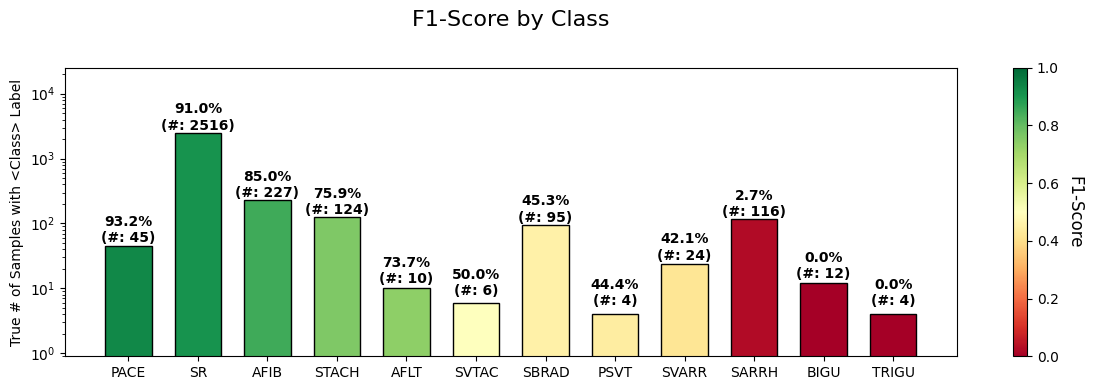

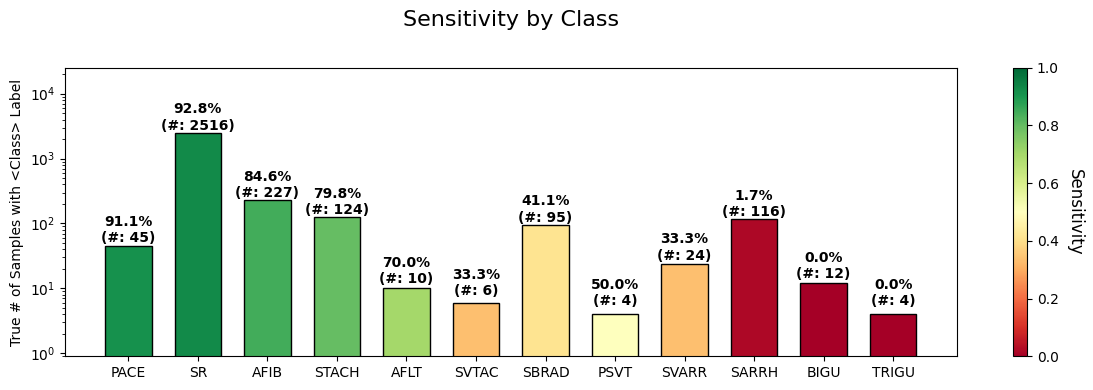

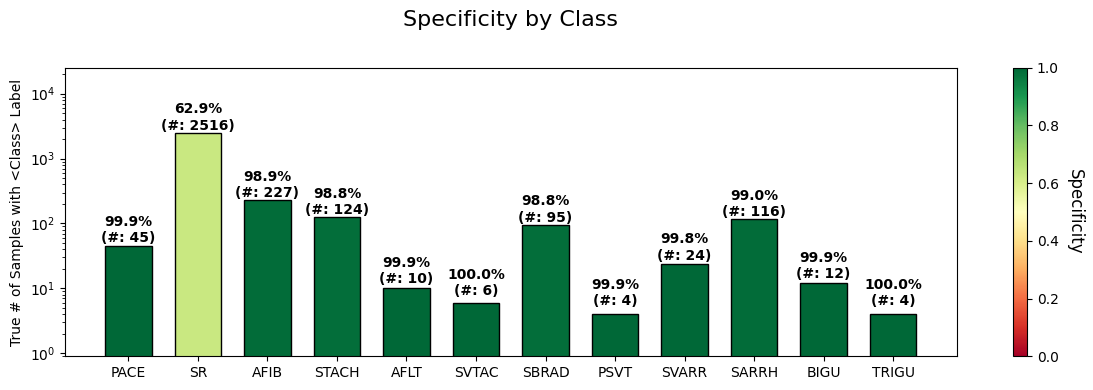

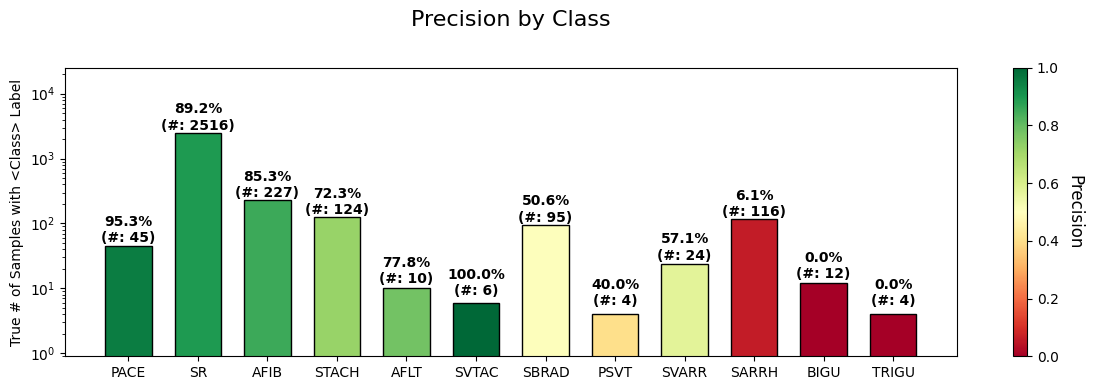

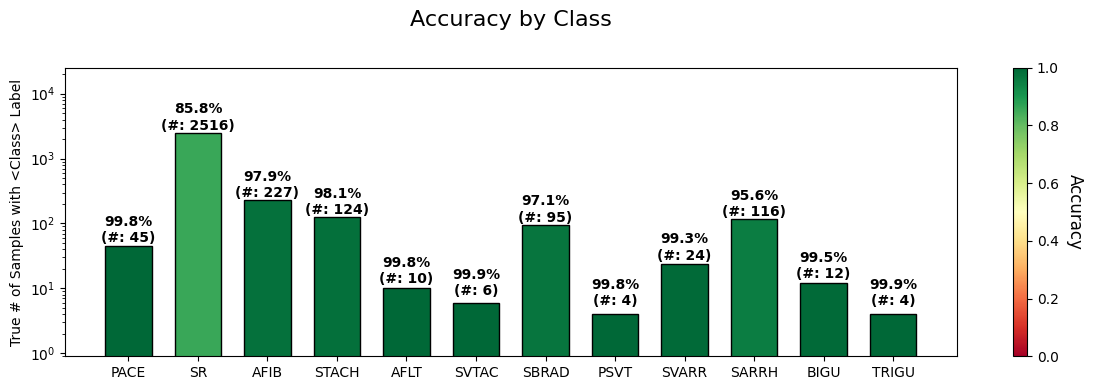

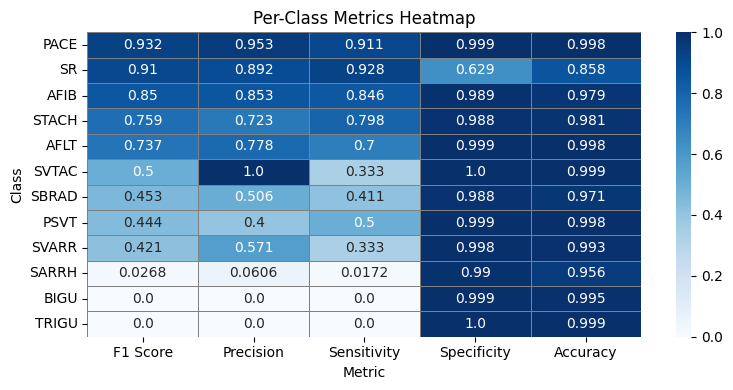

In [225]:

# Get F1, Sensitivity, Specificity, Precision, and Accuracy for all classes
TP=np.sum(((y_true==1)&(y_pred_hot==1)),axis=0) # sum across all rows of samples (axis 0) for each rhythm class column
TN=np.sum(((y_true==0)&(y_pred_hot==0)),axis=0)
FP=np.sum(((y_true==0)&(y_pred_hot==1)),axis=0)
FN=np.sum(((y_true==1)&(y_pred_hot==0)),axis=0)
#print(TP,"\n", TN,"\n", FP, "\n", FN)

with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      f1 = (2*TP)/(2*TP+FP+FN)
      sens=TP/(TP+FN) # "Recall"; How many of the true positive labels were we able to catch
      spec=TN/(TN+FP) # How many of the true negative labels were we able to catch (again (see acc comment) may not be as important due to most samples having only 1 or close 1 label for each)
      prec=TP/(TP+FP) # How many positives did we get correct
      acc=(TP+TN)/(TP+TN+FP+FN) # will be biased because of imbalanced classes and because most samples have only 1, or close to 1, label each (so all of the correctly guessed 0's may skew such that we get misleadingly obtain higher accuracy)

idx = np.argsort(-f1) # Imbalanced classes make F1 a better metric than accuracy -> organize from greatest to least for the charts

# Reorder
label_name_arr = np.array(rhythm_classes)[idx]
TP=TP[idx]
TN=TN[idx]
FP=FP[idx]
FN=FN[idx]
f1 = f1[idx]
sens = sens[idx]
spec = spec[idx]
prec = prec[idx]
acc = acc[idx]
# Clean
f1[np.isnan(f1) | np.isinf(f1)]=0
sens[np.isnan(sens) | np.isinf(sens)]=0
spec[np.isnan(spec) | np.isinf(spec)]=0
prec[np.isnan(prec) | np.isinf(prec)]=0
acc[np.isnan(acc) | np.isinf(acc)]=0


print(f"{"":>5}     ",
      f"{"F1-score":<23}",
      f"{"Sensitivity":<23}",
      f"{"Specificity":<23}",
      f"{"Precision":<23}",
      f"{"Accuracy"}")

for i in range(len(rhythm_classes)):
      f1_str   = f"({2*TP[i]}/{(2*TP+FP+FN)[i]})"
      sens_str = f"({TP[i]}/{(TP+FN)[i]})"
      spec_str = f"({TN[i]}/{(TN+FP)[i]})"
      prec_str = f"({TP[i]}/{(TP+FP)[i]})"
      acc_str  = f"({(TP+TN)[i]}/{(TP+TN+FP+FN)[i]})"

      print(f"{label_name_arr[i]:<5}     ",
            f"{f1[i]:.4f} {f1_str:<16}",
            f"{sens[i]:.4f} {sens_str:<16}",
            f"{spec[i]:.4f} {spec_str:<16}",
            f"{prec[i]:.4f} {prec_str:<16}",
            f"{acc[i]:.4f} {acc_str}")
    

# total labels per class -> use for ordering bar charts so we have an idea of which classes had more vs less data for training (in case low or high amount plays into the prediction ability)
total_per_class=np.sum(y_true, axis=0).astype("int")
total_per_class=total_per_class[idx]
stat_label_list=["F1-Score","Sensitivity","Specificity","Precision","Accuracy"]

# Reminder: charts ordered by class labels with highest -> lowest F1-scores
for statistic,stat_label in zip([f1,sens,spec,prec,acc],stat_label_list):
      fig, ax = plt.subplots(figsize=(12, 4))

      # Colormap from red->yellow->green to display accuracy
      cmap = plt.cm.RdYlGn
      colors = cmap(statistic)

      # Position spaced out bars + create bars
      x = np.arange(len(label_name_arr)) * 1.5 
      bars = ax.bar(x, total_per_class, color=colors, edgecolor="black", width=1.0)

      #Put correct/total counts (and % acc) above each bar
      for i, (stat, tot) in enumerate(zip(statistic, total_per_class)):
            ax.text(x[i], tot + 1, f"{stat*100:.1f}%\n(#: {tot})", ha="center", va="bottom",
                        fontsize=10, color="black", fontweight="bold")

      ax.set_yscale("log")
      # Set class names for tick labels; set ylabel and title
      ax.set_xticks(x)
      ax.set_xticklabels(label_name_arr, fontsize=10)
      ax.set_ylabel("True # of Samples with <Class> Label")
      ax.set_title(f"{stat_label} by Class", fontsize=16, pad=30)
      ax.set_ylim(0.9, max(total_per_class)*10)

      # Colorbar to indicate accuracy level
      sm = plt.cm.ScalarMappable(cmap=cmap)
      sm.set_array([])
      cbar = plt.colorbar(sm, ax=ax)
      cbar.set_label(f"{stat_label}", rotation=270, labelpad=18, fontsize=12)

      plt.tight_layout()
      plt.show()

data = {
      "F1 Score": f1,
      "Precision": prec,
      "Sensitivity": sens,
      "Specificity": spec,
      "Accuracy": acc
}
df = pd.DataFrame(data, index=label_name_arr)

plt.figure(figsize=(8, 4))
sns.heatmap(df, annot=True, fmt=".3", cmap="Blues", cbar=True, linewidths=0.5, linecolor="gray")

plt.title("Per-Class Metrics Heatmap")
plt.ylabel("Class")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

##### Reminder:
###### SR: Sinus Rhythm - normal heart rhythm
###### AFIB: Atrial Fibrillation - irregular and often rapid heart rate
###### STACH: Sinus Tachycardia - increased heart rate
###### SARRH: Sinus Arrhythmia - irregular heart rhythm
###### SBRAD: Sinus Bradycardia - decreased heart rate
###### PACE: Paced Rhythm - heart rhythm controlled by a pacemaker
###### SVARR: Supraventricular Arrhythmia - arrhythmia originating above the ventricles
###### BIGU: Bigeminy - extra heartbeat between every normal, expected heartbeat
###### AFLT: Atrial Flutter - rapid heart rate due to reentrant circuit in the atria
###### SVTAC: Supraventricular Tachycardia - rapid heart rate originating above the ventricles
###### PSVT: Paroxysmal Supraventricular Tachycardia - sudden onset of rapid heart rate
###### TRIGU: Trigeminy - three consecutive beats of different types (e.g., normal followed by two premature beats)

In [209]:
# lets us plot 12 lead ecg samples (given signal waveform, freq, and time_range)
def plot_12lead_ecg_sample(sig, freq, time_range=2.5, true_label=None, pred_label=None): 
    # freq: help us set the time / x-axis (assume 500Hz)
    # time_range: help us set the duration of the signal to display (2.5s default, as if a normal 12 lead ECG sheet)
    # display_len: help us set the length of the signal (number of instances) for display

    lead_labels = ["I", "aVR", "V1", "V4", 
               "II", "aVL", "V2", "V5", 
               "III", "aVF", "V3", "V6"]

    display_len = int(freq*time_range)

    time = np.arange(display_len) / freq

    fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True)
    axes = axes.flatten() # flatten object to 1D (12 element) array just so it is easier to loop over and change each of the 12 leads' axes

    for i, lead in enumerate(lead_labels):
        ax = axes[i]
        ax.plot(time, sig[:display_len, i], lw=0.8, color="black")

        ax.set_title(lead, fontsize=10)
        ax.set_ylabel("mV")
        ax.set_ylim(-1.2, 1.2) # fix to a higher range of vals so we have a continuous looking grid
        ax.set_xlim(0, time_range + 0.1) # ^

        # Set up grid of small boxes (i.e., 0.1mV by 40ms)
        ax.set_yticks(np.arange(-1.2, 1.3, 0.1), minor=True)
        ax.set_xticks(np.arange(0, display_len/freq + 0.1, 0.04), minor=True)
        ax.grid(which='minor', color='lightgrey', linestyle='-', linewidth=0.5)

        # Add thicker lined grid to show bigger boxes (i.e., 0.5mV by 200ms)
        ax.set_yticks(np.arange(-1.2, 1.3, 0.5), minor=False)
        ax.set_xticks(np.arange(0, display_len/freq + 0.1, 0.2), minor=False)
        ax.grid(which='major', color='grey', linestyle='-', linewidth=1)

        ax.set_xlabel("Time (s)") # set for all leads for now

    if(isinstance(true_label,np.ndarray)):
        if (len(true_label)==1):
            true_label=true_label[0]            
        elif(len(true_label)>1):
            true_label=", ".join(true_label)
        else:
            true_label="<Missing>"
    else:
        true_label="<Missing>"
    if (isinstance(pred_label,np.ndarray)):
        if(len(pred_label)==1):
            pred_label=pred_label[0]
        elif(len(pred_label)>1):
            pred_label=", ".join(pred_label)    
        else:
            pred_label="<Missing>"
    else:
        pred_label="<Missing>"

    # Add super title with true/predicted label
    fig.suptitle(f"True: {true_label}  |  Predicted: {pred_label}", fontsize=16, y=1.02)
    fig.subplots_adjust(top=0.88)  # adjust top spacing so title isn't too close to plots

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


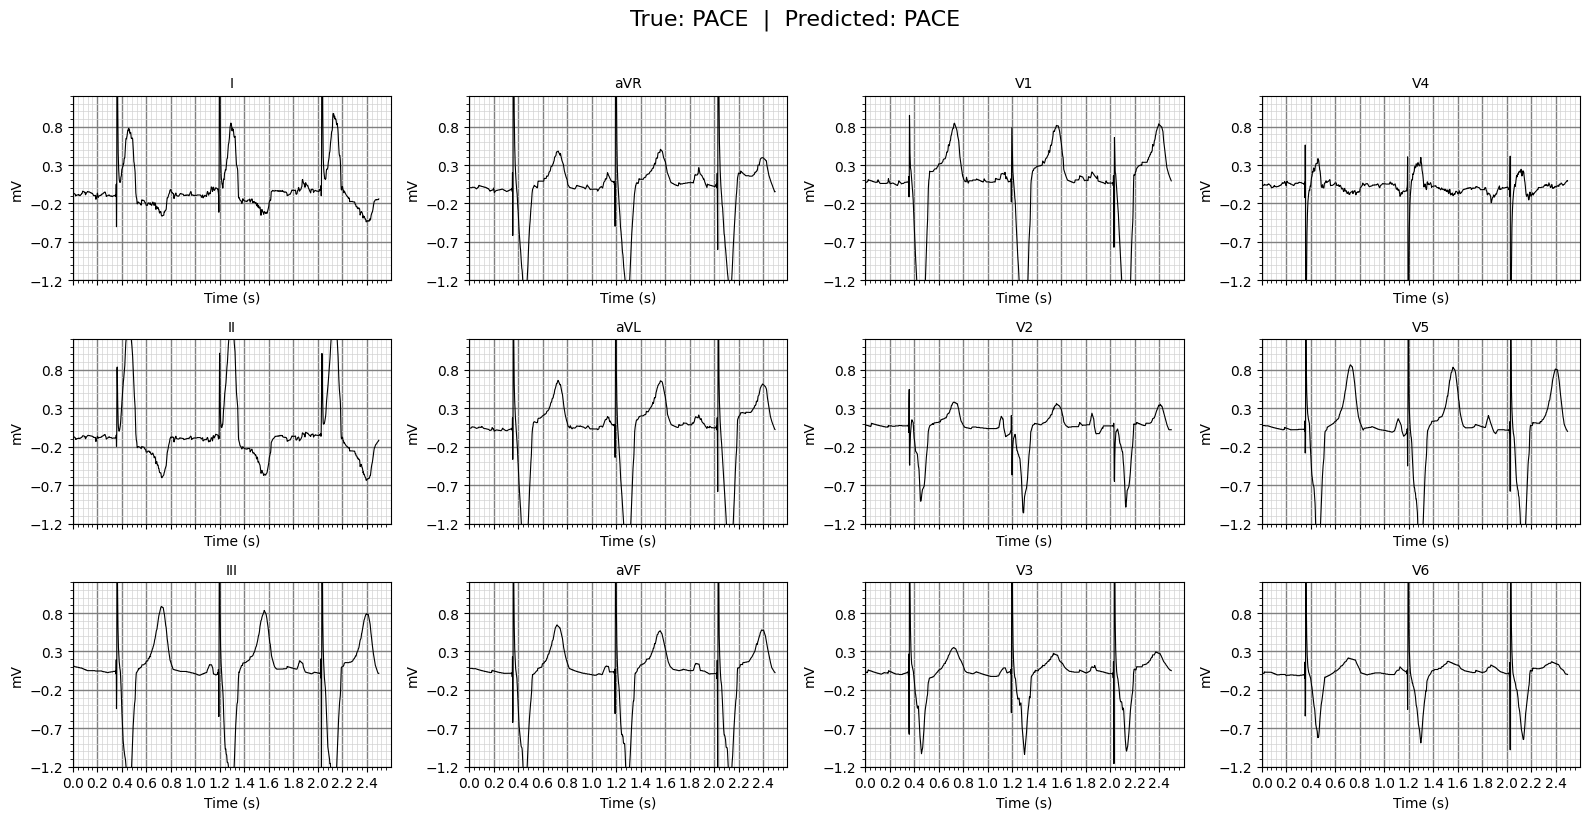

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


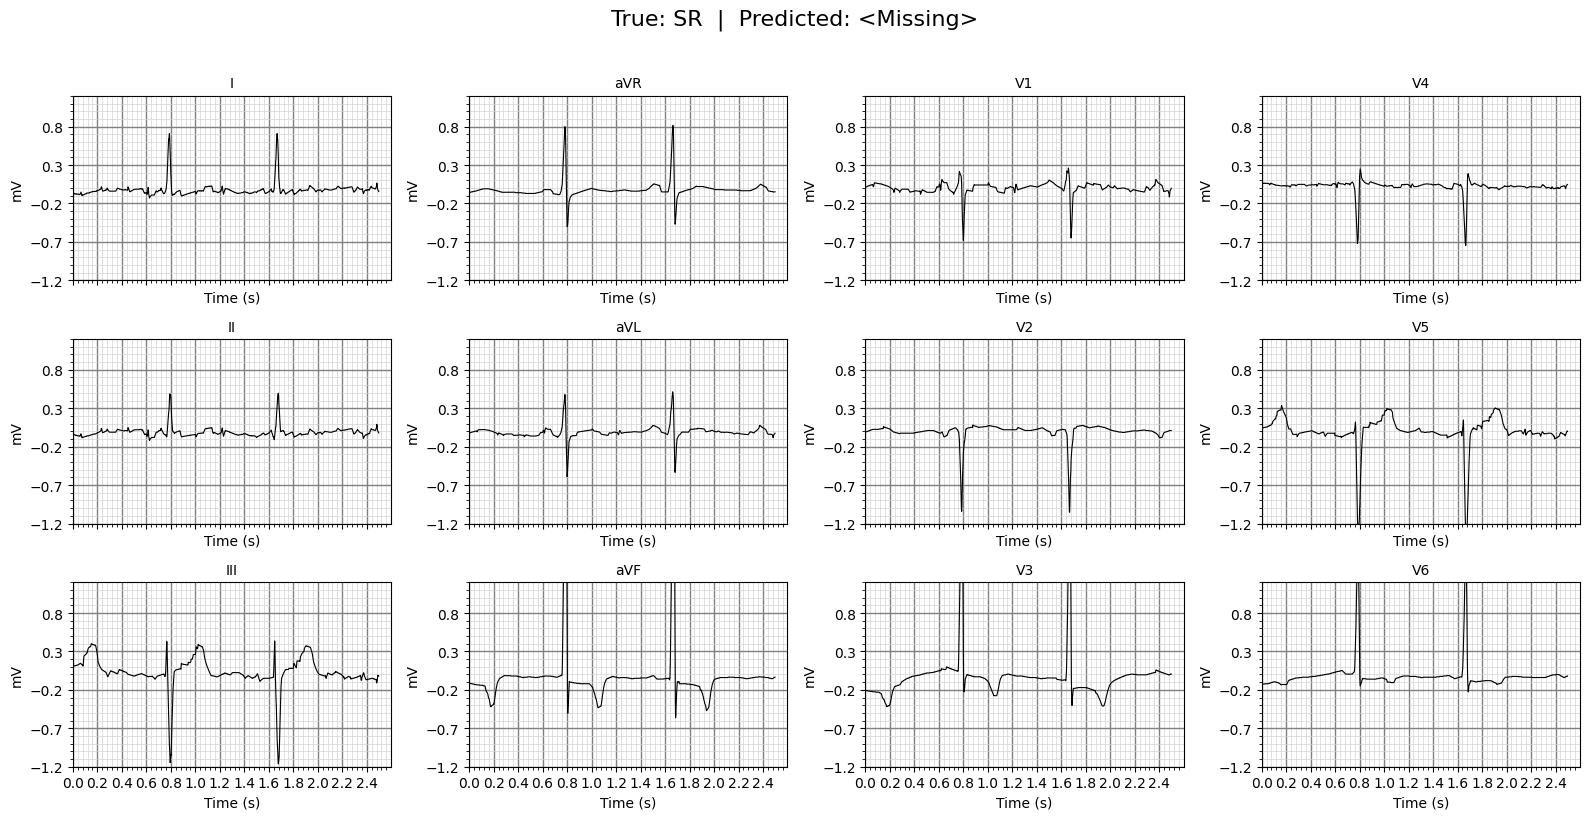

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


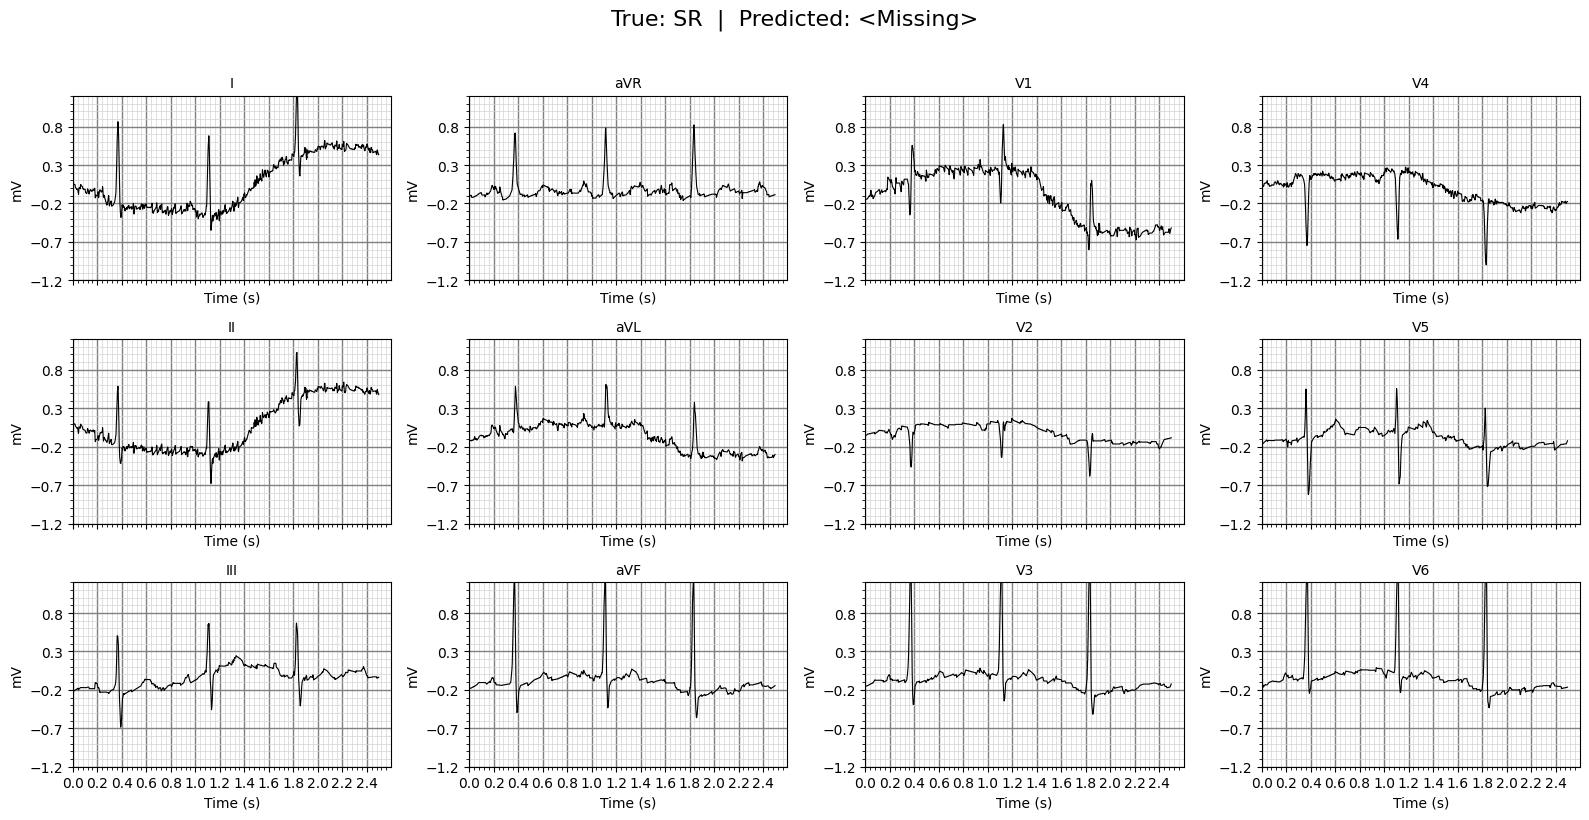

In [217]:
# Visualize just a few examples's results (from the test set)

freq = 500 # help us set the time / x-axis
time_range = 2.5  # display seconds; 2.5s as if a normal 12 lead ECG sheet

for i in range(3): # load first few of test set just for display
    # Get example row from test set + its waveform
    row = df_test.iloc[i]
    sig, _ = load_hr_record(row)

    # Prepare input for final_model prediction
    X_input = sig[:int(freq*time_range), :].astype(np.float32)  # shape (1250, 12); freq*time_range = 1250 ("display length" needed for 2.5 sec of signals for 500Hz)
    if X_input.shape[0] < 5000:
        pad_len = 5000 - X_input.shape[0]
        X_input = np.pad(X_input, ((0,pad_len),(0,0)), mode='constant')

    X_input = np.expand_dims(X_input, axis=0)  # shape (1, 5000, 12)

    # Predict using final model
    y_pred_sample = final_model.predict(X_input)[0]  # shape: (1, n_classes) -> (n_classes)
    #y_pred_idx = np.argmax(y_pred_sample)

    rhythm_classes_arr=np.array(rhythm_classes)

    # Set up one/multi-hot vectors
    threshold=0.5
    
    # Option 1: Cut off based on threshold - may leave some samples with no guesses
    y_pred_sample=(y_pred_sample>=threshold).astype(int)
    pred_label_sample = rhythm_classes_arr[y_pred_sample==1]
    # Option 2: Force minimum of one label per sample (based on max prob. in given sample row)
    #if(np.any(y_pred_sample>=threshold)):
    #    y_pred_sample=(y_pred_sample>=threshold).astype(int)
    #    pred_label_sample = rhythm_classes_arr[y_pred_sample==1]
    #else:
    #    y_pred_sample_idx=np.argmax(y_pred_sample)
    #    pred_label_sample = [rhythm_classes[y_pred_sample_idx]]
    
    true_label_sample = rhythm_classes_arr[y_true[i]==1] # just use true values from test set from earlier
    plot_12lead_ecg_sample(sig, freq=freq, time_range=time_range, true_label=true_label_sample, pred_label=pred_label_sample)



In [8]:
# Load later
from keras.models import load_model
#final_model = load_model(pathtosave)
final_model = load_model("ptbxl_rhythms_CNNmodel.keras")